## Isoform analysis by genome alignment, junction-based alignment vectorization, and decision-tree isoform assignment

This notebook provides the ability for both manual isoform annotation (by means of specifying a decision tree) and automated clustering (using DBSCAN).

**Inputs and Outputs**
- Inputs:
  - transcriptome annotation `.gtf` file (e.g. GENCODE v37)
  - genome assembly reference `.fasta` file
  - MAS-seq array elements `.bam` file
  - A gene name to study (e.g. PTPRC)
- Outputs:
  - Figures
  - `.bam` file for all the queries mapping to the selected gene
  - `.bam` file for all the queries mapping to the selected gene stratified by leiden cluster id
  - `.h5ad` AnnData file of manual isoform annotations

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('./sources'))

import matplotlib.pylab as plt
import colorcet as cc
import numpy as np
import pandas as pd
from time import time
import logging
import pickle
import gffutils
import pysam
import umap
import scanpy as sc
import pickle

import isoform_utils as iso
import vis_utils as vis

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use('dark_background')

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_info = print

## Paths

In [2]:
repo_root = '/home/jupyter/mb-ml-data-disk/MAS-seq-analysis'
prefix = 'M132TS_MAS_15x.v4'

gtf_path = os.path.join(
    repo_root, 'resources/gencode.v37.annotation.gtf')
db_path = os.path.join(
    repo_root, 'resources/gencode.v37.annotation.db')
gs_to_gid_map_pkl_path = os.path.join(
    repo_root, 'resources/gencode.v37.annotation.gs_to_gid_map.pkl')
ref_path = os.path.join(
    repo_root, 'resources/Homo_sapiens.GRCh38.dna.primary_assembly.fa')

# path to the MAS-seq .bam file
bam_path = os.path.join(
    repo_root,
    'data/t-cell-vdj/long/alignments/v4/M132TS_MAS_15x_array_elements_longbow_extracted_genome_aligned.bam')

## (Optional) Make a gffutils `.db` file

Must be run once.

In [3]:
if not os.path.exists(db_path):
    
    # this takes a while ...
    fn = gffutils.example_filename(gtf_path)
    db = gffutils.create_db(
        fn,
        db_path,
        keep_order=True,
        disable_infer_genes=True,
        disable_infer_transcripts=True)

## (Optional) Gene symbol to Gene ID map

Must be run once.

In [4]:
if not os.path.exists(gs_to_gid_map_pkl_path):
    
    # this takes a while ...
    gs_to_gid_map = dict()
    for gene in db.all_features():
        gid = gene.attributes['gene_id'][0]
        gs = gene.attributes['gene_name'][0]
        gs_to_gid_map[gs] = gid

    with open(gs_to_gid_map_pkl_path, 'wb') as f:
        pickle.dump(gs_to_gid_map, f)

## Configuration

In [5]:
# gene symbol to study
gs = 'PTPRC'

# smallest vectorization interval length
min_vectorization_interval_length = 5

# start and end padding for fetching alignments
fetch_padding = 250  # fetch records with this much paiing
gene_body_padding = 500  # ultimately, allow alignments within this much margin

# minimum / maximum alignment mapping quality 
min_mapping_quality = 0
max_mapping_quality = np.inf

# options: 'gtf', 'alignments'
junctions_source = 'alignments'

# what .gtf features to include for vectorization? (only used if junctions_source == 'gtf')
included_feature_types = ['UTR', 'exon', 'intron']

# options for alignment-based junction inference
alignment_block_min_gap = 5
junction_merge_gap = 3
min_rel_junction_read_support = 0.01
min_abs_junction_read_support = 100
include_end_segments = False
consider_read_endpoints_as_junctions = True

# options: 'relative', 'absolute', 'quantized' 
vectorization_strategy = 'relative'

# minimum vectorization interval overlap to quantize to 1 (only used if vectorization_strategy == 'quantized')
rel_overlap_quantization_threshold = 0.25
abs_overlap_quantization_threshold = 100

# remove records that overlap with too few of the vectorization intervals
min_vector_weight = 0

# (for plotting) remove segments with coverage less than `min_covearge_for_compressed_plot`
min_covearge_for_compressed_plot = 0

# (for plotting) pad kept genomics regions from left and right by `nonzero_coverage_positions_pad`
nonzero_coverage_positions_pad = 200

## Load GENCODE annotations

In [6]:
# load gffutils .db
db = gffutils.FeatureDB(db_path)

# load gs to gid map
with open(gs_to_gid_map_pkl_path, 'rb') as f:
    gs_to_gid_map = pickle.Unpickler(f).load()

gid = gs_to_gid_map[gs.upper()]

# generate introns
gene_db = gffutils.create_db(
    db.children(gid),
    ':memory:',
    keep_order=True,
    disable_infer_genes=True,
    disable_infer_transcripts=True)

gene_db.update(gene_db.create_introns())

# get feature intervals
feature_interval_list = iso.get_feature_interval_list(gene_db, included_feature_types)

## Load BAM alignments

In [7]:
fetch_start = min(interval.start for interval in feature_interval_list) - fetch_padding
fetch_end = max(interval.end for interval in feature_interval_list) + fetch_padding
contig = feature_interval_list[0].contig
contig_without_str = contig if contig.find('chr') == -1 else contig[3:]

# load alignments
raw_alignment_list, alignment_stats = iso.fetch_alignments(
    bam_path=bam_path,
    fetch_contig=contig,
    fetch_start=fetch_start,
    fetch_end=fetch_end,
    gene_body_padding=gene_body_padding,
    min_mapping_quality=min_mapping_quality,
    max_mapping_quality=max_mapping_quality)

# update the fetch region based on the endpoints of the alignments
fetch_start = np.min([fetch_start] + [aln.reference_start for aln in raw_alignment_list])
fetch_end = np.max([fetch_end] + [aln.reference_end for aln in raw_alignment_list])

# load reference
ref_file = pysam.Fastafile(ref_path)
gene_seq = ref_file.fetch(start=fetch_start, end=fetch_end, reference=contig_without_str)

# statistics
log_info(f'Fetch reference interval: {contig, fetch_start, fetch_end}')
log_info(f'Total queries: {alignment_stats["num_total_queries"]}')
log_info(f'Total alignments: {alignment_stats["num_total_alignments"]}')
log_info(f'Number of queries with single low quality alignments: {alignment_stats["num_queries_with_single_low_quality_alignment"]}')
log_info(f'Number of queries with single high quality alignments: {alignment_stats["num_queries_with_single_high_quality_alignment"]}')
log_info(f'Number of queries with multiple low quality alignments: {alignment_stats["num_queries_with_multiple_low_quality_alignments"]}')
log_info(f'Number of queries with multiple high quality alignments: {alignment_stats["num_queries_with_multiple_high_quality_alignments"]}')
log_info(f'Number of multi-mapped queries with a single outstanding alignment: {alignment_stats["num_queries_with_outstanding_alignment"]}')
log_info(f'Number of queries with out out gene body alignment: {alignment_stats["num_queries_with_out_of_gene_body_alignments"]}')

Fetch reference interval: ('chr1', 198638207, 198757854)
Total queries: 12685
Total alignments: 12709
Number of queries with single low quality alignments: 0
Number of queries with single high quality alignments: 12663
Number of queries with multiple low quality alignments: 0
Number of queries with multiple high quality alignments: 22
Number of multi-mapped queries with a single outstanding alignment: 0
Number of queries with out out gene body alignment: 15


## Generate vectorization intervals

In [8]:
if junctions_source == 'gtf':
    
    vectorization_interval_list = iso.get_vectorization_interval_list_from_features(feature_interval_list)
    
elif junctions_source == 'alignments':
    
    raw_junctions, raw_counts = iso.get_junctions_and_counts_from_alignments(
        raw_alignment_list,
        alignment_block_min_gap=alignment_block_min_gap,
        consider_read_endpoints_as_junctions=consider_read_endpoints_as_junctions)

    merged_junctions, merged_counts = iso.merge_junctions(
        raw_junctions,
        raw_counts,
        junction_merge_gap=junction_merge_gap)

    filtered_junctions, filtered_counts = iso.filter_junctions(
        merged_junctions,
        merged_counts,
        total_reads=len(raw_alignment_list),
        min_rel_junction_read_support=min_rel_junction_read_support,
        min_abs_junction_read_support=min_abs_junction_read_support)

    reference_start, reference_end = iso.get_alignment_bounds(raw_alignment_list)

    vectorization_interval_list = iso.get_vectorization_interval_list_from_junctions(
        junctions=filtered_junctions,
        reference_start=reference_start,
        reference_end=reference_end,
        reference_contig=contig,
        gene_id=gid,
        include_end_segments=include_end_segments,
        min_vectorization_interval_length=min_vectorization_interval_length)
    
    log_info(f'Number of raw junctions: {len(raw_junctions)}')
    log_info(f'Number of merged junctions: {len(merged_junctions)}')
    log_info(f'Number of filtered junctions: {len(filtered_junctions)}')

else:
    
    raise ValueError
    
# statistics
num_vectorization_intervals = len(vectorization_interval_list)
vectorization_interval_lengths = [interval.end - interval.start + 1 for interval in vectorization_interval_list]
min_vectorization_interval_length = min(vectorization_interval_lengths)
max_vectorization_interval_length = max(vectorization_interval_lengths)

log_info(f'Number of vectorization genomics intervals: {num_vectorization_intervals}')
log_info(f'Smallest vectorization interval length: {min_vectorization_interval_length}')
log_info(f'Largest vectorization interval length: {max_vectorization_interval_length}')

Number of raw junctions: 3425
Number of merged junctions: 1157
Number of filtered junctions: 75
Number of vectorization genomics intervals: 74
Smallest vectorization interval length: 20
Largest vectorization interval length: 53006


In [9]:
# get vectorized representation
vectorized_alignments_nv = iso.get_vectorized_alignments_matrix(
    alignment_list=raw_alignment_list,
    vectorization_interval_list=vectorization_interval_list,
    abs_overlap_quantization_threshold=abs_overlap_quantization_threshold,
    rel_overlap_quantization_threshold=rel_overlap_quantization_threshold,
    vectorization_strategy=vectorization_strategy)

# get coverage
coverage_matrix_ni = iso.get_binary_reference_coverage_sparse_matrix(
    alignment_list=raw_alignment_list,
    ref_interval_start=fetch_start,
    ref_interval_end=fetch_end)

total_vector_weight_n = np.sum(vectorized_alignments_nv, -1)
total_coverage_i = np.asarray(coverage_matrix_ni.sum(0)).flatten()

In [10]:
# filter
n_alignments_all = len(raw_alignment_list)
passing_alignments_n = np.ones((n_alignments_all,), dtype=np.bool)

passing_alignments_n = passing_alignments_n & (total_vector_weight_n > min_vector_weight)
n_removed_low_weight = n_alignments_all - np.sum(passing_alignments_n)

filtered_alignment_list = [
    raw_alignment_list[idx] for idx in range(len(raw_alignment_list)) if passing_alignments_n[idx]]
filtered_vectorized_alignments_mv = vectorized_alignments_nv[passing_alignments_n]
filtered_coverage_matrix_mi = coverage_matrix_ni[passing_alignments_n]

log_info(f'Removed {n_removed_low_weight} alignments for having relative segment coverage weight < {min_vector_weight}.')

Removed 4 alignments for having relative segment coverage weight < 0.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


## Visualize vectorization intervals, junctions, coverage, etc.

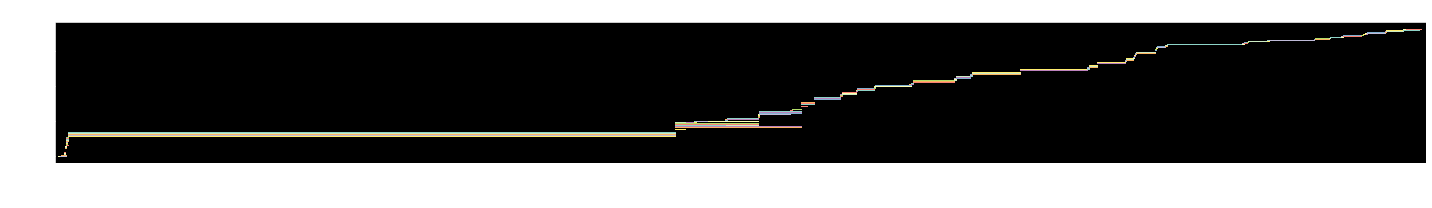

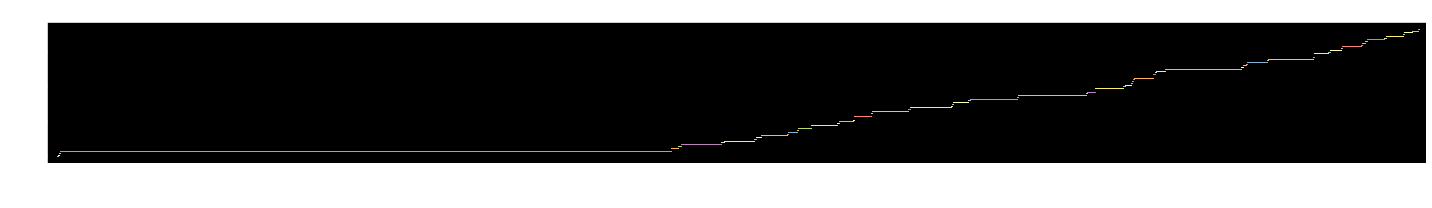

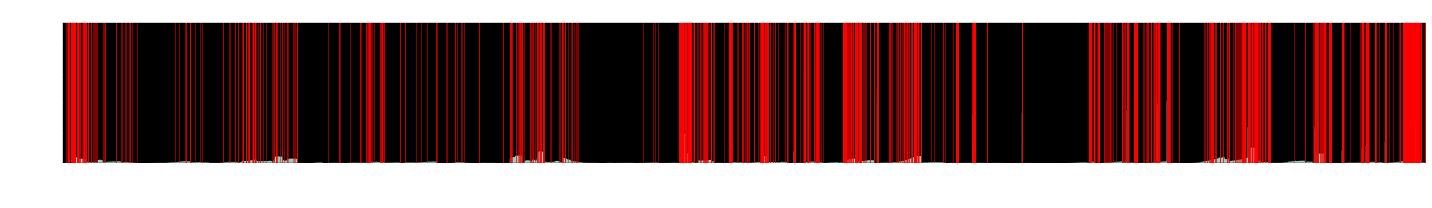

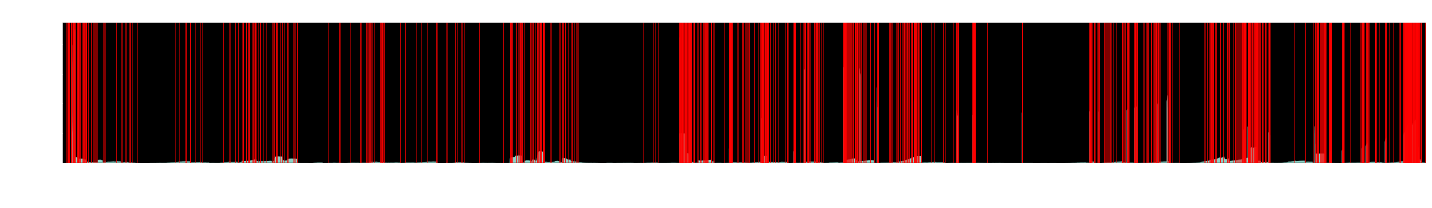

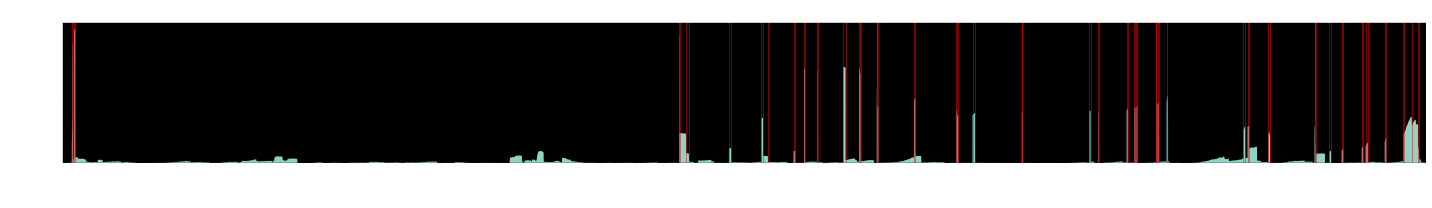

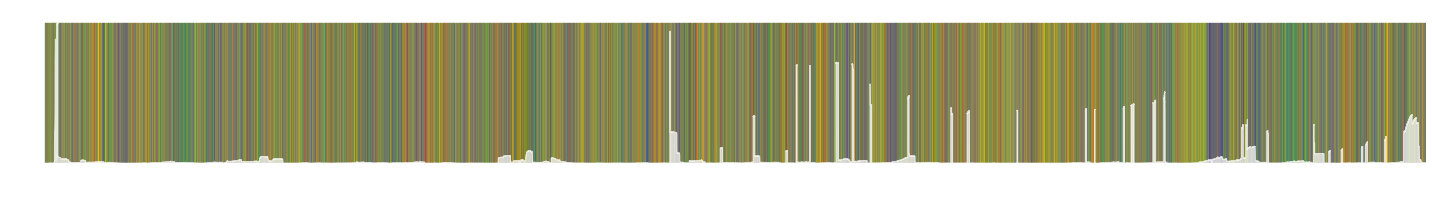

In [11]:
# if you have ipywidgets installed, you can make interactive plots by replacing
# the following line with:
#
# %matplotlib widget
#

%matplotlib inline

coverage_transform = lambda x: x

# visualize intervals
fig = plt.figure(figsize=(20, 3))
ax = plt.gca()
for idx, interval in enumerate(feature_interval_list):
    start = interval.start
    end = interval.end
    ax.plot([start, end], [idx, idx], lw=1)
ax.set_xlabel('position')
ax.set_ylabel('interval index')
ax.set_title('Feature Intervals (from GTF)')
ax.set_xlim((fetch_start, fetch_end))
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.tight_layout()


fig = plt.figure(figsize=(20, 3))
ax = plt.gca()
for idx, interval in enumerate(vectorization_interval_list):
    start = interval.start
    end = interval.end
    ax.plot([start, end], [idx, idx], lw=1)
ax.set_xlabel('position')
ax.set_ylabel('interval index')
ax.set_title('Vectorization Intervals')
ax.set_xlim((fetch_start, fetch_end))
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.tight_layout()


transformed_total_coverage_i = coverage_transform(total_coverage_i)

fig = plt.figure(figsize=(20, 3))
ax = plt.gca()

ax.fill_between(np.arange(fetch_start, fetch_end + 1), transformed_total_coverage_i)
for junction in raw_junctions:
    ax.axvline(junction, color='red', lw=0.5)
ax.set_ylabel('Coverage')
ax.set_xlabel(f'Genomic position on {contig}')
ax.set_xlim((fetch_start, fetch_end))
ax.set_title('Raw junctions')
ax.set_ylim(bottom=0.)
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.tight_layout()


fig = plt.figure(figsize=(20, 3))
ax = plt.gca()

ax.fill_between(np.arange(fetch_start, fetch_end + 1), transformed_total_coverage_i)
for junction in merged_junctions:
    ax.axvline(junction, color='red', lw=0.5)
ax.set_ylabel('Coverage')
ax.set_xlabel(f'Genomic position on {contig}')
ax.set_xlim((fetch_start, fetch_end))
ax.set_title('Merged junctions')
ax.set_ylim(bottom=0.)
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.tight_layout()


fig = plt.figure(figsize=(20, 3))
ax = plt.gca()

ax.fill_between(np.arange(fetch_start, fetch_end + 1), transformed_total_coverage_i)
for junction in filtered_junctions:
    ax.axvline(junction, color='red', lw=0.5)
ax.set_ylabel('Coverage')
ax.set_xlabel(f'Genomic position on {contig}')
ax.set_xlim((fetch_start, fetch_end))
ax.set_title('Filtered junctions')
ax.set_ylim(bottom=0.)

fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.tight_layout()


fig = plt.figure(figsize=(20, 3))
ax = plt.gca()

nucleotide_to_color_map = {
    'T': [1., 1., 0.],
    'A': [0., 0., 1.],
    'C': [1., 0., 0.],
    'G': [0., 1., 0.]
}
gene_seq_im = np.asarray(list(map(nucleotide_to_color_map.get, gene_seq)))[None, :, :]
ax.imshow(gene_seq_im, aspect='auto', extent=[fetch_start, fetch_end, 0., np.max(transformed_total_coverage_i)])
ax.fill_between(np.arange(fetch_start, fetch_end + 1), transformed_total_coverage_i, color='white', alpha=0.7)
ax.set_xlabel(f'Genomic position on {contig}')
ax.set_title('Gene sequence')
ax.set_ylim(bottom=0.)

fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.tight_layout()

## Detailed coverage visualization

In [12]:
# mark positions with above-threshold coverage for plotting
filtered_total_coverage_i = np.asarray(filtered_coverage_matrix_mi.sum(0)).flatten()
plot_positions_set = set()
for pos in np.nonzero(filtered_total_coverage_i >= min_covearge_for_compressed_plot)[0].tolist() + filtered_junctions:
    plot_positions_set.update(set(
        np.arange(pos - nonzero_coverage_positions_pad, pos + nonzero_coverage_positions_pad, + 1).tolist()))
plot_positions = sorted(set(pos for pos in plot_positions_set if 0 <= pos < fetch_end - fetch_start))

# generate annotations for plooting
feature_to_annotation_track_map = iso.get_feature_to_annotation_track_map(
    feature_interval_list=feature_interval_list,
    included_feature_types=included_feature_types,
    ref_contig=contig,
    ref_interval_start=fetch_start,
    ref_interval_end=fetch_end)

# add junctions to annotations
for i_junction, junction in enumerate(filtered_junctions):
    junction_track = np.zeros((fetch_end - fetch_start + 1), dtype=np.int8)
    junction_track[junction - fetch_start] = 1
    feature_to_annotation_track_map[f'junction_{i_junction}'] = junction_track

# add vectorization segments to annotations
for i_segment, segment in enumerate(vectorization_interval_list):
    segment_track = np.zeros((fetch_end - fetch_start + 1), dtype=np.int8)
    segment_track[(segment.start - fetch_start):(segment.end - fetch_start)] = 1
    feature_to_annotation_track_map[f'segment_{i_segment}'] = segment_track
    
junction_colors = (dict(color=[0.5, 0.1, 0.1], alpha=0.5, lw=1),)
segment_colors = (dict(color='cyan', alpha=0.1), dict(color='green', alpha=0.1))
text_props = dict(fontsize=8, color='white', ha='center', bbox=dict(facecolor='black', alpha=0.5))

plot_annotation_manifest = []
for i_junction in range(len(filtered_junctions)):
    manifest = (f'junction_{i_junction}', junction_colors[i_junction % len(junction_colors)], f'{i_junction}')
    plot_annotation_manifest.append(manifest)

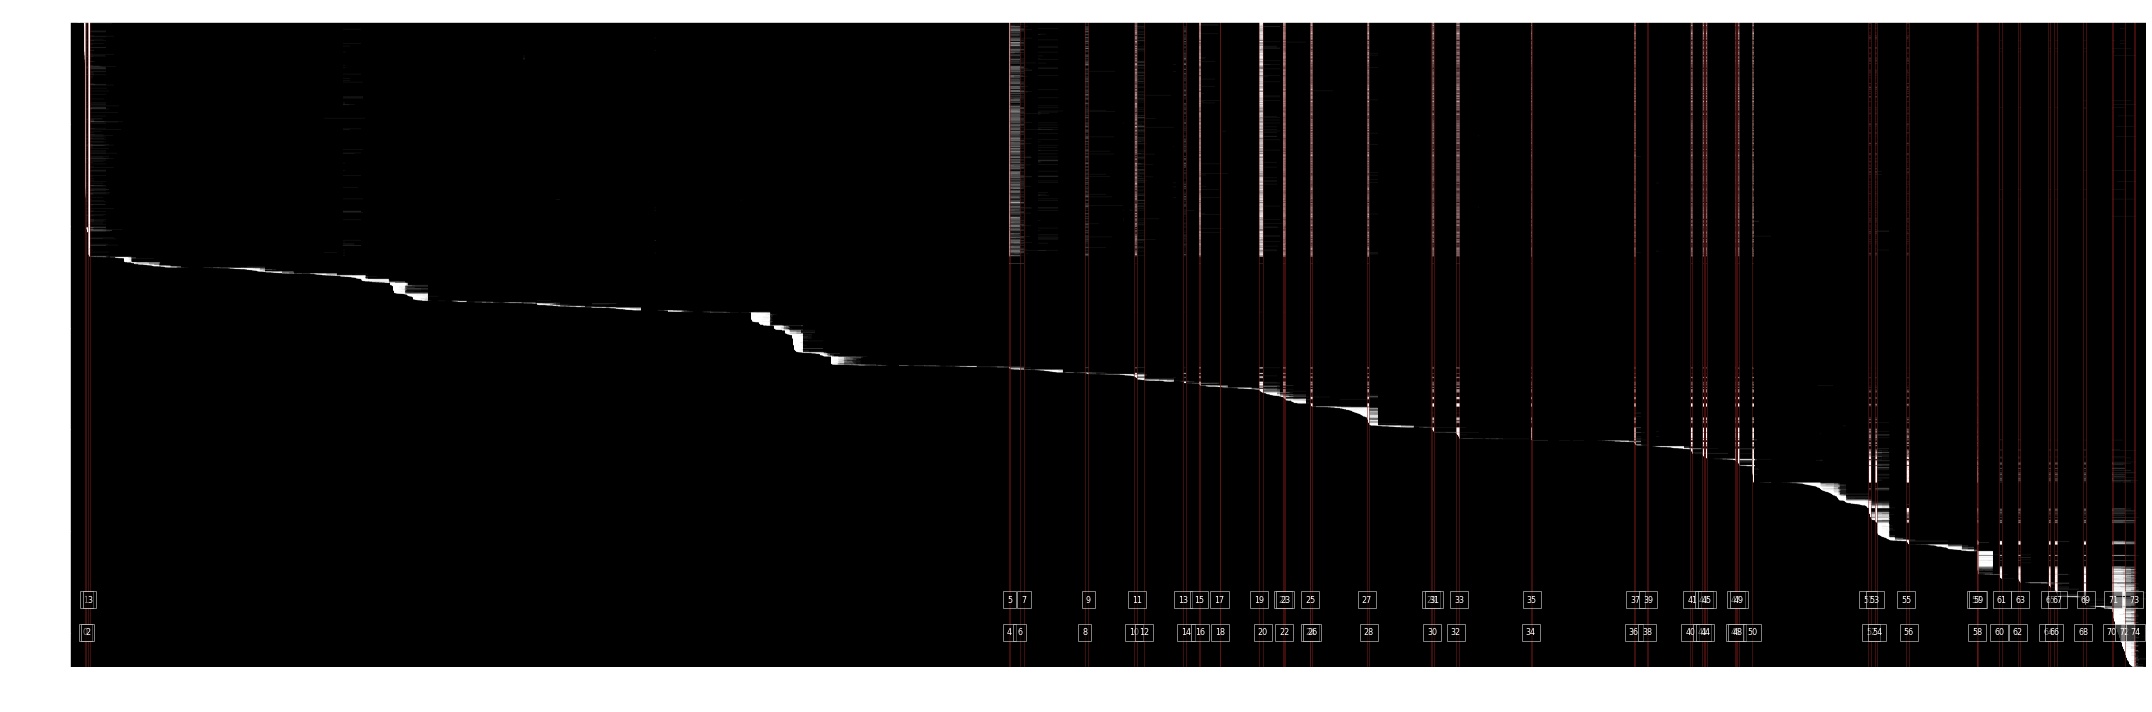

In [13]:
%matplotlib inline

# if we have too many reads, let's skip some of them uniformly (for plotting)
max_reads_to_plot = np.inf
n_all_reads = filtered_coverage_matrix_mi.shape[0]
if n_all_reads > max_reads_to_plot:
    reads_to_plot_indices = np.sort(np.random.permutation(n_all_reads)[:max_reads_to_plot])
else:
    reads_to_plot_indices = np.arange(n_all_reads)

# coverage to plot
coverage_img_mj = filtered_coverage_matrix_mi[reads_to_plot_indices, :][:, plot_positions].todense()

fig, ax = plt.subplots(figsize=(30, 10))

# plot individual reads
ax.imshow(coverage_img_mj, aspect='auto', cmap=plt.cm.Greys_r)

# plot annotations
text_ypos_str = 'down'
for desc in plot_annotation_manifest:
    name = desc[0]
    props = desc[1]
    text = desc[2]
    track = feature_to_annotation_track_map[name][plot_positions]
    nnz = np.sum(track > 0)
    
    if nnz < 1:
        continue 
    elif nnz == 1:  # line
        ax.axvline(track.argmax(), **props)
    else:  # region
        ax.axvspan(track.argmax(), len(track) - track[::-1].argmax(), **props)
        
    if len(text) > 0:
        text_xpos = 0.5 * (len(track) - track[::-1].argmax() + track.argmax())
        if text_ypos_str == 'down':
            text_ypos = 0.95 * coverage_img_mj.shape[0]
            text_ypos_str = 'up'
        else:
            text_ypos = 0.9 * coverage_img_mj.shape[0]
            text_ypos_str = 'down'
        ax.text(text_xpos, text_ypos, text, **text_props)
        

compressed_str = 'compressed coordinates; ' if min_covearge_for_compressed_plot > 0 else 'actual coordinates; '
suffix_str = 'compressed_coordinates' if min_covearge_for_compressed_plot > 0 else 'actual_coordinates'
ax.set_xlabel(f'Genomic position (forward strand) [{compressed_str}start offset: {contig}:{fetch_start}]')
ax.set_ylabel('Read index')
ax.set_title(f'gene symbol: {gs}    minMQ: {min_mapping_quality}    maxMQ: {max_mapping_quality}')

plt.tight_layout()

plt.savefig(f'./output/{gs}__long_mRNA__{suffix_str}.png', dpi=100)
with open(f'./output/{gs}__junctions.tsv', 'w') as f:
    f.write('JUNCTION_INDEX\tPOSITION\n')
    for i, j in enumerate(filtered_junctions):
        f.write(f'{i}\t{contig}:{j}\n')

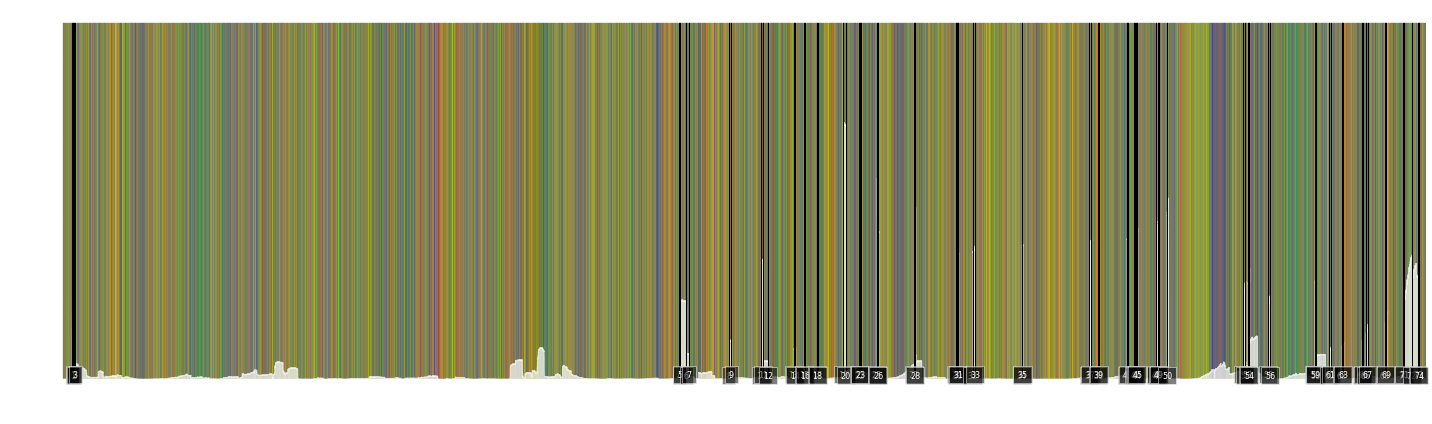

In [14]:
# if you have ipywidgets installed, you can make interactive plots by replacing
# the following line with:
#
# %matplotlib widget
#

%matplotlib inline

coverage_transform = lambda x: x

transformed_total_coverage_i = coverage_transform(total_coverage_i)

fig = plt.figure(figsize=(20, 6))
ax = plt.gca()

nucleotide_to_color_map = {
    'T': [1., 1., 0.],
    'A': [0., 0., 1.],
    'C': [1., 0., 0.],
    'G': [0., 1., 0.]
}
gene_seq_im = np.asarray(list(map(nucleotide_to_color_map.get, gene_seq)))[None, :, :]
ax.imshow(gene_seq_im, aspect='auto', extent=[fetch_start, fetch_end, 0., np.max(transformed_total_coverage_i)])
ax.fill_between(np.arange(fetch_start, fetch_end + 1), transformed_total_coverage_i, color='white', alpha=0.7)
ax.set_xlabel(f'Genomic position on {contig}')
ax.set_title('Gene sequence')
ax.set_ylim(bottom=0.)
for i, junction in enumerate(filtered_junctions):
    ax.axvline(junction, color='black', lw=1)
    y_pos = 10 if i % 2 == 0 else 20
    ax.text(junction, y_pos, str(i), **text_props)
ax.set_ylabel('Coverage')

fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.tight_layout()

## (Optional) Manual isoform labeling

Note: either run manual labeling or automatic labeling (coming up later)

A decision tree such as,

```
isoform_decision_tree = {
    (segment_index_1,): ('X', {
        (segment_index_2, segment_index_3): ('A', {
            (segment_index_4,): ('B', dict())
        }),
    }),
    (segment_index_5,): ('Y', dict()),
    (segment_index_6, segment_index_7): ('Z', dict())
    }),
}
```

is interpreted as follows:

- if the read has coverage over `segment_index_1` and but not over both `segment_index_2` and `segment_index_3`, then decision for this branch is `X`
  - else if it has coverage over both `segment_index_2` and `segment_index_3` but not over `segment_index_4`, then decision for this branch is `A`
    - else if it has coverage over `segment_index_4`, then the deicison for this branch is `B`
- if the read has coverage over `segment_index_5`, then the decision for this branch is `Y`
- if the read has coverage over `segment_index_6` and `segment_index_7`, then enter decision `Z` (isoform suffix: Z)

A read is parsed according to the decision tree and all compatible decision branches are identified. Ultimately, a unique name is generated by concatenating all compatible leaf nodes.

More examples:

```
Segments covered     1  2  3  4  5  6  7
Read_1               o  o  o  o  o  o  o   =>  Unassigned
Read_2               X  o  o  o  o  o  o   =>  X
Read_3               X  o  o  o  o  X  X   =>  XZ
Read_4               X  o  o  o  o  o  X   =>  X
Read_5               o  X  X  o  o  o  o   =>  Unassigned
Read_6               o  o  o  o  X  o  o   =>  Y
Read_7               X  o  o  X  X  o  o   =>  XY
Read_8               o  o  o  o  x  X  X   =>  YZ
Read_9               X  X  X  X  o  o  o   =>  B
Read_10              X  X  X  o  X  X  X   =>  AYZ
Read_11              X  X  o  X  X  X  X   =>  XYZ
Read_12              X  X  X  X  X  X  o   =>  BY
Read_13              X  X  X  X  X  X  X   =>  BYZ
...
```

Notes:

- Not all segments need to appear in the deicision tree;  the decision can be based on a handful of segments (e.g. variable exons)
- The code extends a python tuple of segments to check for coverage at each node;  if testing for coverage over a single segment is intend, you must still enter it as a tuple, e.g. `(5,)` for segment index `5`
- The decision tree is a nested dictionary;  To end the decision tree at some leaf node, use an empty dictionary, i.e. `dict()`.

In [15]:
from typing import List, Tuple


def traverse_isoform_decision_tree(
        segment_overlap_vector: np.ndarray,
        decision_tree: dict,
        coverage_threshold: float,
        traversal=None) -> List[Tuple[List[Tuple[int]], dict]]:
    
    # root
    if traversal == None:
        traversal = [([], decision_tree)]
        
    extended = False
    extended_traversal = []
    for branch in traversal:
        path = branch[0]
        head_decision_tree = branch[1]
        branch_extended = False
        for segment_indices, (_, head_decision_subtree) in head_decision_tree.items():
            if all(segment_overlap_vector[segment_index] >= coverage_threshold for segment_index in segment_indices):
                branch_extended = True
                extended = True
                extended_traversal.append((path.copy() + [segment_indices], head_decision_subtree))
        if not branch_extended and path != []:
            extended_traversal.append(branch)
    
    if extended:
        return traverse_isoform_decision_tree(
            segment_overlap_vector,
            decision_tree,
            coverage_threshold,
            extended_traversal)
    else:
        return traversal

    
def get_all_compat_isoforms(
        segment_overlap_vector: np.ndarray,
        decision_tree: dict,
        coverage_threshold: float) -> List[List[int]]:
    traversal = traverse_isoform_decision_tree(
        segment_overlap_vector,
        decision_tree,
        coverage_threshold)
    paths = []
    for branch in traversal:
        paths.append(branch[0])
    return paths


def generate_isoform_name(
        paths: List[List[int]],
        decision_tree: dict,
        naming_prefix: str) -> str:
    suffix_set = set()
    for path in paths:
        subtree = decision_tree
        suffix = 'Unassigned'
        while len(path):
            suffix = subtree[path[0]][0]
            subtree = subtree[path[0]][1]
            path = path[1:]
        suffix_set.add(suffix)
    return naming_prefix + '_' + ''.join(sorted(list(suffix_set)))

### Decision tree defined by vectorization intervals

Use this cell if you know the vectorization interval index you would like to use to build the decision tree.

In [150]:
# coverage threshold
coverage_threshold = 0.1
naming_prefix = gs

# mininum number of reads for an isoform label;  if lower, it will be demoted to Unassigned
min_reads_per_cluster = 10

isoform_decision_tree = {
  (1,): ('A', dict()),
  (3,): ('B', dict()),
  (4,): ('C', dict()),
  (14,): ('D', dict()),
  (28,): ('E', dict()),
  (28,): ('F', dict())
}


# print interval list appearing in the decision tree
def print_decision_tree(decision_tree):
    for interval_indices, (name, sub_tree) in decision_tree.items():
        for interval_index in interval_indices:
            print(f'Vectorizatrion interval {interval_index} coordinates (used in {name}): {vectorization_interval_list[interval_index]}')
        print_decision_tree(sub_tree)
        
print_decision_tree(isoform_decision_tree)

Vectorizatrion interval 1 coordinates (used in A): Interval(feature_type='vectorization_interval_ENSG00000081059.20', contig='chr5', start=134115661, end=134115674)
Vectorizatrion interval 3 coordinates (used in B): Interval(feature_type='vectorization_interval_ENSG00000081059.20', contig='chr5', start=134115740, end=134115908)
Vectorizatrion interval 4 coordinates (used in C): Interval(feature_type='vectorization_interval_ENSG00000081059.20', contig='chr5', start=134115908, end=134116033)
Vectorizatrion interval 14 coordinates (used in D): Interval(feature_type='vectorization_interval_ENSG00000081059.20', contig='chr5', start=134140795, end=134140888)
Vectorizatrion interval 28 coordinates (used in F): Interval(feature_type='vectorization_interval_ENSG00000081059.20', contig='chr5', start=134147031, end=134147973)


### Decision tree defined by genomic intervals

Use this cell if you know the genomic position of exons you would like to use to build the decision tree.

In [16]:
# coverage threshold
coverage_threshold = 0.1
naming_prefix = gs

# mininum number of reads for an isoform label;  if lower, it will be demoted to Unassigned
min_reads_per_cluster = 10

from isoform_utils import Interval, get_overlap_fraction

def get_overlapping_vectorization_intervals(interval: Interval, overlap_threshold=0.75) -> Tuple[int]:
    vect_indices = []
    for vect_index, vect_interval in enumerate(vectorization_interval_list):
        if get_overlap_fraction(vect_interval.start, vect_interval.end, interval.start, interval.end) > overlap_threshold:
            vect_indices.append(vect_index)
    return tuple(vect_indices)
    
interval_Z = Interval(feature_type='vectorization_interval_ENSG00000081237.20', contig='chr1', start=198692373, end=198692959)
interval_W = Interval(feature_type='vectorization_interval_ENSG00000081237.20', contig='chr1', start=198692959, end=198693202)
interval_O = Interval(feature_type='vectorization_interval_ENSG00000081237.20', contig='chr1', start=198703297, end=198703372)
interval_A = Interval(feature_type='vectorization_interval_ENSG00000081237.20', contig='chr1', start=198696711, end=198696909)
interval_B = Interval(feature_type='vectorization_interval_ENSG00000081237.20', contig='chr1', start=198699563, end=198699704)
interval_C = Interval(feature_type='vectorization_interval_ENSG00000081237.20', contig='chr1', start=198702386, end=198702530)
interval_L = Interval(feature_type='vectorization_interval_ENSG00000081237.20', contig='chr1', start=198732300, end=198732390)
interval_XL = Interval(feature_type='vectorization_interval_ENSG00000081237.20', contig='chr1', start=198741868, end=198742026)

# PTPRC assignments
isoform_decision_tree = {
    get_overlapping_vectorization_intervals(interval_O): ('O', {
        get_overlapping_vectorization_intervals(interval_A): ('A', dict()),
        get_overlapping_vectorization_intervals(interval_B): ('B', dict()),
        get_overlapping_vectorization_intervals(interval_C): ('C', dict())
    }),
}

In [17]:
isoform_names_m = []
for segment_overlap_vector in filtered_vectorized_alignments_mv:
    isoform_name = generate_isoform_name(
        get_all_compat_isoforms(
            segment_overlap_vector,
            isoform_decision_tree,
            coverage_threshold),
        isoform_decision_tree,
        naming_prefix)
    isoform_names_m.append(isoform_name)

unassigned_name = naming_prefix + '_Unassigned'

# filter
from collections import Counter

isoform_names_counter = Counter(isoform_names_m)
isoform_name_reassignment_map = dict()
for isoform_name, counts in isoform_names_counter.items():
    if counts >= min_reads_per_cluster:
        isoform_name_reassignment_map[isoform_name] = isoform_name
    else:
        isoform_name_reassignment_map[isoform_name] = unassigned_name
isoform_names_m = list(map(isoform_name_reassignment_map.get, isoform_names_m))
                       
# post
isoform_names_set = set(isoform_names_m)
try:
    isoform_names_set.remove(unassigned_name)
except KeyError:
    pass
isoform_name_to_isoform_label_map = {unassigned_name: -1}
for i_isoform, isoform_name in enumerate(sorted(isoform_names_set)):
    isoform_name_to_isoform_label_map[isoform_name] = i_isoform
isoform_label_to_isoform_name_map = {label: name for name, label in isoform_name_to_isoform_label_map.items()}
isoform_labels_m = np.asarray(list(map(isoform_name_to_isoform_label_map.get, isoform_names_m)))
isoform_labels_set = set(isoform_labels_m)
isoform_labels_list = sorted(isoform_labels_set)
isoform_names_list = list(map(isoform_label_to_isoform_name_map.get, isoform_labels_list))
num_isoform_clusters = len(isoform_labels_set)

print(f'Number of isoform clusters: {num_isoform_clusters}')
print(isoform_names_list)

Number of isoform clusters: 7
['PTPRC_Unassigned', 'PTPRC_AB', 'PTPRC_ABC', 'PTPRC_B', 'PTPRC_BC', 'PTPRC_C', 'PTPRC_O']


## (Optional) Automatic isoform labeling

Using DBSCAN clustering.

Note: either run manual labeling (ealier) or automatic labeling.

In [26]:
from sklearn.cluster import DBSCAN

# clustering resolution
naming_prefix = gs
eps = 1.0
min_samples = 5

# what features to use for clustering?
clustering_input_data_mv = filtered_vectorized_alignments_mv

# DBSCAN
isoform_labels_m = DBSCAN(
    eps=eps,
    min_samples=min_samples,
    metric='l1').fit_predict(clustering_input_data_mv)

isoform_labels_set = set(isoform_labels_m)
isoform_labels_list = sorted(isoform_labels_set)
unassigned_name = naming_prefix + '_Unassigned'
isoform_label_to_isoform_name_map = dict()
for i_isoform, isoform_label in enumerate(isoform_labels_list):
    isoform_label_to_isoform_name_map[isoform_label] = f'{naming_prefix}_{str(isoform_label)}'
isoform_label_to_isoform_name_map[-1] = unassigned_name
isoform_name_to_isoform_label_map = {name: label for label, name in isoform_label_to_isoform_name_map.items()}
isoform_names_list = list(map(isoform_label_to_isoform_name_map.get, isoform_labels_list))
isoform_names_set = set(isoform_names_list)
num_isoform_clusters = len(isoform_labels_set)

print(f'Number of isoform clusters: {num_isoform_clusters}')
print(isoform_names_list)

Number of isoform clusters: 30
['PTPRC_Unassigned', 'PTPRC_0', 'PTPRC_1', 'PTPRC_2', 'PTPRC_3', 'PTPRC_4', 'PTPRC_5', 'PTPRC_6', 'PTPRC_7', 'PTPRC_8', 'PTPRC_9', 'PTPRC_10', 'PTPRC_11', 'PTPRC_12', 'PTPRC_13', 'PTPRC_14', 'PTPRC_15', 'PTPRC_16', 'PTPRC_17', 'PTPRC_18', 'PTPRC_19', 'PTPRC_20', 'PTPRC_21', 'PTPRC_22', 'PTPRC_23', 'PTPRC_24', 'PTPRC_25', 'PTPRC_26', 'PTPRC_27', 'PTPRC_28']


## Plot coverage of assigned transcripts to each isoform

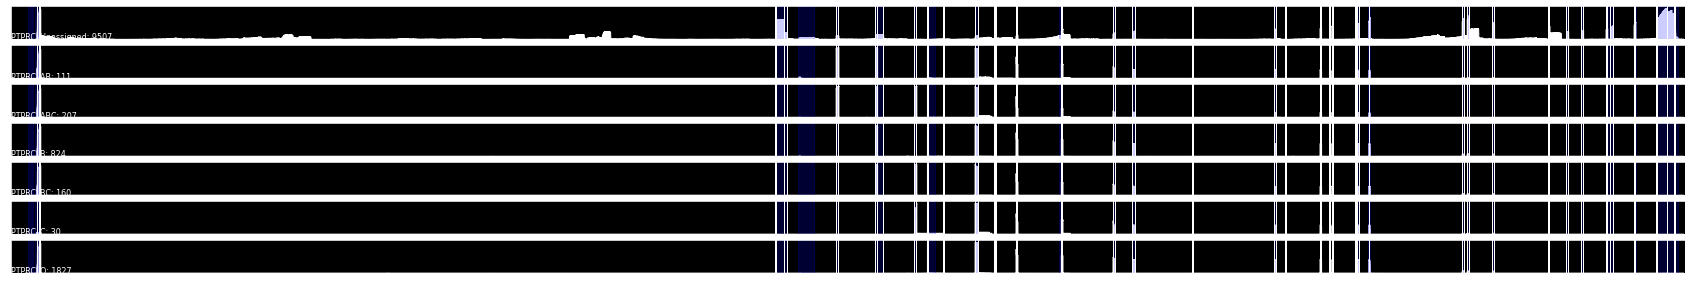

In [18]:
%matplotlib inline

# mark positions with above-threshold coverage for plotting
filtered_total_coverage_i = np.asarray(filtered_coverage_matrix_mi.sum(0)).flatten()
plot_positions_set = set()
for pos in np.nonzero(filtered_total_coverage_i >= min_covearge_for_compressed_plot)[0].tolist() + filtered_junctions:
    plot_positions_set.update(set(
        np.arange(pos - nonzero_coverage_positions_pad, pos + nonzero_coverage_positions_pad, + 1).tolist()))
plot_positions = sorted(set(pos for pos in plot_positions_set if 0 <= pos < fetch_end - fetch_start))

# calculate coverage for each isoform
normalized_isoform_covearge_i_list = []
for i_isoform in range(num_isoform_clusters):
    isoform_label = isoform_labels_list[i_isoform]
    isoform_coverage_i = np.asarray(filtered_coverage_matrix_mi[isoform_labels_m == isoform_label].sum(0)).flatten()
    isoform_coverage_i = isoform_coverage_i / (1e-6 + np.sum(isoform_coverage_i))
    normalized_isoform_covearge_i_list.append(isoform_coverage_i)

# generate annotations for plooting
feature_to_annotation_track_map = iso.get_feature_to_annotation_track_map(
    feature_interval_list=feature_interval_list,
    included_feature_types=included_feature_types,
    ref_contig=contig,
    ref_interval_start=fetch_start,
    ref_interval_end=fetch_end)

# feature annotations
feature_to_annotation_track_map = iso.get_feature_to_annotation_track_map(
    feature_interval_list=feature_interval_list,
    included_feature_types=included_feature_types,
    ref_contig=contig,
    ref_interval_start=fetch_start,
    ref_interval_end=fetch_end)

# add junctions to annotations
junctions_track_i = np.zeros((fetch_end - fetch_start + 1),)
trunc_junctions = [junction for junction in filtered_junctions if fetch_end > junction >= fetch_start]
junctions_track_i[np.asarray(trunc_junctions) - fetch_start] = 1.
feature_to_annotation_track_map['junction'] = junctions_track_i


nrows = num_isoform_clusters
fig, axs = plt.subplots(ncols=1, nrows=nrows, figsize=(30, nrows * 0.7))
    
for i_isoform in range(num_isoform_clusters):
    
    isoform_label = isoform_labels_list[i_isoform]    
    isoform_name = isoform_names_list[i_isoform]    
    num_reads_support = np.sum(isoform_labels_m == isoform_label)
    normalized_isoform_covearge_i = normalized_isoform_covearge_i_list[i_isoform]
    nnz_normalized_isoform_covearge_i = normalized_isoform_covearge_i[plot_positions]
    ax = axs[i_isoform]
    
    # annotate axis
    vis.annotate_axis_with_tracks(
        feature_to_annotation_track_map,
        included_features=[
            'exon',
            'junction'],
        feature_to_color_map={
            'exon': 'blue',
            'junction': 'white',
            'intron': 'yellow'},
        ax=ax,
        included_position_mask=plot_positions,
        alpha_region=0.2)

    # plot coverage
    ax.fill_between(
        np.arange(len(nnz_normalized_isoform_covearge_i)), nnz_normalized_isoform_covearge_i,
        color='white'
    )
        
    ax.set_yticks([])
    ax.text(-1000, 0, f'{isoform_name}: {num_reads_support}', fontsize=8)
    
    if i_isoform != num_isoform_clusters - 1:
        ax.set_xticks([])
    
    ax.set_xlim((-1000, len(plot_positions) + 100))
    ax.set_ylim(bottom=0.)

## Visualize where each isoform is expressed in the short reads embedding map

In [19]:
# inputs
input_prefix = 'M132TS_immune.v4.harmonized'
output_path = 'output/t-cell-vdj-cite-seq'
final_short_adata_raw_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.short.stringtie.final.raw.h5ad')
final_short_adata_sct_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.short.stringtie.final.sct.h5ad')
final_long_adata_raw_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.long.stringtie.final.raw.h5ad')
final_long_adata_sct_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.long.stringtie.final.sct.h5ad')

In [20]:
# load GEX adata
# note: we are loading the output of mb_07_harmonize_long_short
leiden_key = 'mehrtash_leiden'
embedding_key = 'X_umap_SCT_short'

adata = sc.read(final_short_adata_raw_h5_path)

# color by leiden cluster
filtered_alignment_barcode_list = [
    alignment.get_tag('CB') for alignment in filtered_alignment_list]

# map from barcode to leiden
barcode_to_leiden_id_map = dict()
adata_barcode_list = adata.obs.index.values
adata_leiden_id_list = np.asarray(adata.obs[leiden_key].values)
for barcode, leiden_id in zip(adata_barcode_list, adata_leiden_id_list):
    barcode_to_leiden_id_map[barcode] = leiden_id

# leiden id for each alignment
filtered_alignment_leiden_list = []
for barcode in filtered_alignment_barcode_list:
    leiden_id = '-1'
    if barcode in barcode_to_leiden_id_map:
        leiden_id = barcode_to_leiden_id_map[barcode]
    filtered_alignment_leiden_list.append(leiden_id)

# all leiden ids
adata_leiden_id_list = adata.obs[leiden_key].values.categories.values.tolist()

# colors
alpha = 0.8

import colorcet as cc
leiden_colors = [cc.cm.glasbey(i)[:3] + (alpha,) for i in range(len(adata_leiden_id_list))]
adata_color_list = []
leiden_id_to_idx_map = {leiden_id: idx for idx, leiden_id in enumerate(adata_leiden_id_list)}
for leiden_id in adata.obs[leiden_key]:
    if leiden_id == '-1':
        color = (0., 0., 0., 0.,)
    else:
        color = leiden_colors[leiden_id_to_idx_map[leiden_id]]
    adata_color_list.append(color)

Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].


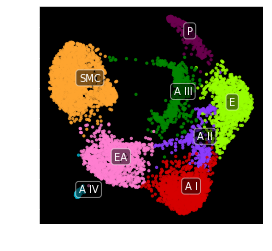

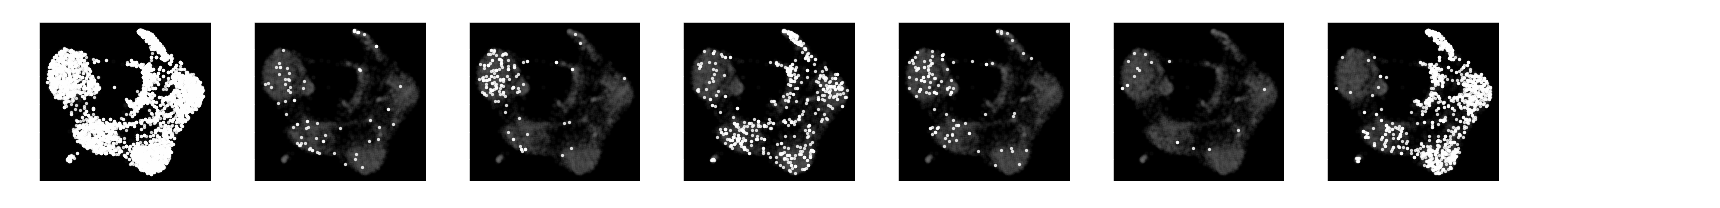

In [21]:
# min number of cells per isoform (otherwise, isoform not show)
min_cells_per_isoform = 1

# leiden
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(
    adata.obsm[embedding_key][:, 0],
    adata.obsm[embedding_key][:, 1],
    color=adata_color_list,
    s=5)

for leiden_id in adata_leiden_id_list:
    x_values = adata.obsm[embedding_key][adata.obs[leiden_key] == leiden_id, 0]
    y_values = adata.obsm[embedding_key][adata.obs[leiden_key] == leiden_id, 1]
    x_c, y_c = np.mean(x_values), np.mean(y_values)
    ax.text(x_c, y_c, leiden_id, bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))

# highlights
ncols = 8
nrows = int(np.ceil(len(set(isoform_labels_set)) / ncols))
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 * ncols, 3 * nrows))

barcode_to_adata_idx_map = {adata.obs.index.values[idx]: idx for idx in range(len(adata))}

i_ax = 0
for i_isoform in range(num_isoform_clusters):
    isoform_id_highlight = isoform_labels_list[i_isoform]
    isoform_name = isoform_names_list[i_isoform]   
    ax = axs.flatten()[i_ax]
    
    highlight_barcodes = [
        barcode for i, barcode in enumerate(filtered_alignment_barcode_list)
        if isoform_labels_m[i] == isoform_id_highlight]
    highlight_adata_indices = []
    highlight_leiden_ids = []
    for barcode in highlight_barcodes:
        if barcode in barcode_to_adata_idx_map:
            highlight_adata_indices.append(barcode_to_adata_idx_map[barcode])
    
    n_expressing_cells = len(highlight_adata_indices)
    if n_expressing_cells >= min_cells_per_isoform:
        
        ax.scatter(
            adata.obsm[embedding_key][:, 0],
            adata.obsm[embedding_key][:, 1],
            color='gray',
            s=10,
            alpha=0.05)

        ax.scatter(
            adata.obsm[embedding_key][highlight_adata_indices, 0],
            adata.obsm[embedding_key][highlight_adata_indices, 1],
            c='white',
            s=5, alpha=0.8)
        
        ax.set_title(f'{isoform_name}')
        i_ax += 1
    
    else:        
        log_info(f'Isoform {isoform_name} has only {n_expressing_cells} expressing cells and was not shown.')
    
# get rid of extra panels
for j in range(i_ax, len(axs.flatten())):
    axs.flatten()[j].axis('off')
    
fig.tight_layout()

## Generate query name list that map the selected gene

In [22]:
from collections import defaultdict

alignment_list_by_isoform_map = defaultdict(list)
alignment_list_by_leiden_id_map = defaultdict(list)
prefix = 'M132TS'

for isoform_name, alignment in zip(isoform_names_m, filtered_alignment_list):
    alignment_list_by_isoform_map[isoform_name].append(alignment)
    
for barcode, alignment in zip(filtered_alignment_barcode_list, filtered_alignment_list):
    try:
        leiden_id = barcode_to_leiden_id_map[barcode]
        alignment_list_by_leiden_id_map[leiden_id].append(alignment)
    except:
        pass
    
# export TXT
for isoform_name, alignment_list in alignment_list_by_isoform_map.items():
    with open(os.path.join(repo_root, f'output/t-cell-vdj-cite-seq/{prefix}__{isoform_name}__query_names.txt'), 'w') as f:
        for alignment in alignment_list:
            f.write(alignment.qname + '\n')

## Export a `.bam` of all alignments

- all queries
- queries stratified by leiden cluster index

Note: `ggsashimi` does not accept CIGAR strings that include `X` and `=`.  We will replace these operators with `M` (match) in the produced `.bam` files.

In [23]:
from itertools import groupby

_CIGAR_SIMPLIFY_MAP = {
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 0,
    8: 0,
    9: 9
}

def simplify_cigartuples(cigartuples):
    """
        The operations are:
        +-----+--------------+-----+
        |M    |BAM_CMATCH    |0    |
        +-----+--------------+-----+
        |I    |BAM_CINS      |1    |
        +-----+--------------+-----+
        |D    |BAM_CDEL      |2    |
        +-----+--------------+-----+
        |N    |BAM_CREF_SKIP |3    |
        +-----+--------------+-----+
        |S    |BAM_CSOFT_CLIP|4    |
        +-----+--------------+-----+
        |H    |BAM_CHARD_CLIP|5    |
        +-----+--------------+-----+
        |P    |BAM_CPAD      |6    |
        +-----+--------------+-----+
        |=    |BAM_CEQUAL    |7    |
        +-----+--------------+-----+
        |X    |BAM_CDIFF     |8    |
        +-----+--------------+-----+
        |B    |BAM_CBACK     |9    |
        +-----+--------------+-----+
    """
    
    # replace X and = with M
    new_cigartuples = []
    for k, v in cigartuples:
        new_cigartuples.append((_CIGAR_SIMPLIFY_MAP[k], v))
    
    # merge tandem maches
    simplified_cigartuples = []
    for g in groupby(new_cigartuples, key=lambda cigartuple: cigartuple[0]):
        cigar_op = g[0]
        tups = list(g[1])
        if cigar_op == 0:  # match
            total_matches = sum(tup[1] for tup in tups)
            simplified_cigartuples.append((0, total_matches))
        else:
            simplified_cigartuples += tups
    
    return simplified_cigartuples

In [24]:
# export BAM (all queries)
header = pysam.AlignmentFile(bam_path).header
with pysam.AlignmentFile(f'./output/bam/{prefix}.{gs}.bam', mode='wb', header=header) as f:
    for isoform_name, alignment_list in alignment_list_by_isoform_map.items():
        for alignment in alignment_list:
            new_alignment = pysam.AlignedSegment.fromstring(alignment.to_string(), header)
            new_alignment.cigartuples = simplify_cigartuples(new_alignment.cigartuples)
            new_alignment.set_tag('IN', isoform_name)
            f.write(new_alignment)

In [25]:
# export BAM (stratified by leiden id)
header = pysam.AlignmentFile(bam_path).header
for leiden_id in adata_leiden_id_list:
    fixed_leiden_id = leiden_id.replace(' ', '_')
    with pysam.AlignmentFile(f'./output/bam/{prefix}.{gs}.{fixed_leiden_id}.bam', mode='wb', header=header) as f:
        for alignment in alignment_list_by_leiden_id_map[leiden_id]:
            new_alignment = pysam.AlignedSegment.fromstring(alignment.to_string(), header)
            new_alignment.cigartuples = simplify_cigartuples(new_alignment.cigartuples)
            new_alignment.set_tag('IN', isoform_name)
            f.write(new_alignment)

## Export an AnnData object for the manual annotations

In [26]:
from scipy.sparse import csr_matrix

adata_barcodes = adata.obs.index.values
expr_ni = np.zeros((len(adata_barcodes), len(isoform_names_list)))

barcode_to_adata_row_idx = {barcode: row_idx for row_idx, barcode in enumerate(adata_barcodes)}
isoform_name_to_adata_col_idx = {isoform_name: col_idx for col_idx, isoform_name in enumerate(isoform_names_list)}
for isoform_name, barcode in zip(isoform_names_m, filtered_alignment_barcode_list):
    if barcode in barcode_to_adata_row_idx:
        row_idx = barcode_to_adata_row_idx[barcode]
        col_idx = isoform_name_to_adata_col_idx[isoform_name]
        expr_ni[row_idx, col_idx] += 1

prefix = 'manual__'
adata_isoform_names_list = [prefix + isoform_name for isoform_name in isoform_names_list]
new_var = pd.DataFrame(
    dict(
        transcript_ids=adata_isoform_names_list,
        gene_ids=[prefix + gid] * len(adata_isoform_names_list), 
        gene_names=[prefix + gs] * len(adata_isoform_names_list), 
        transcript_names=adata_isoform_names_list,
        de_novo_gene_ids=['N/A'] * len(adata_isoform_names_list),
        de_novo_transcript_ids=adata_isoform_names_list,
        is_de_novo=[True] * len(adata_isoform_names_list),
        is_gene_id_ambiguous=[False] * len(adata_isoform_names_list)),
    index=adata_isoform_names_list)

new_adata = sc.AnnData(
    X=csr_matrix(expr_ni),
    var=new_var)

new_adata.obs.index = adata.obs.index
new_adata.write(os.path.join(repo_root, 'output/t-cell-vdj-cite-seq/manual_annotations', f'adata_long_manual__{gs}.h5ad'))

... storing 'gene_ids' as categorical
... storing 'gene_names' as categorical
... storing 'de_novo_gene_ids' as categorical
